<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/train2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-metrics

In [2]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [3]:
data_dir = "/content/drive/My Drive/dataset/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 70

classes = ["Child's room",  "Museum", "Restaurant"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break

    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  3


In [4]:
X, Y = create_data(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Restaurant
(530, 70, 64, 64, 3)
(133, 70, 64, 64, 3)
(530, 3)
(133, 3)


In [12]:
model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

#model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format="channels_last"))
#model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation="softmax"))

model.summary()

opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

#history = model.fit(x=X_train, y=y_train, epochs=40, batch_size=8, shuffle=True, validation_split=0.2, callbacks=callbacks)
history = model.fit(x=X_train, y=y_train, epochs=60, batch_size=10, shuffle=True, validation_split=0.2)
print("Accuracy : %.4f" % (model.evaluate(X_test, y_test)[1]))

# Result
loss, acc = model.evaluate(X_test, y_test)
print("\nLoss: {}, Acc: {}".format(loss,acc))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)              

ValueError: ignored

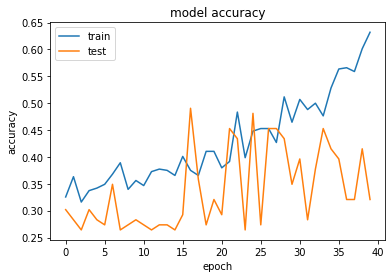

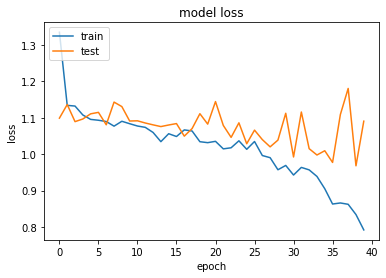

result:  2
actual result:  [0 1 0]
report

              precision    recall  f1-score   support

           0       0.67      0.52      0.59        42
           1       0.24      0.33      0.28        46
           2       0.19      0.16      0.17        45

    accuracy                           0.33       133
   macro avg       0.36      0.34      0.34       133
weighted avg       0.36      0.33      0.34       133



In [7]:
## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predictions = model.predict(X_test)
print('result: ',np.argmax(predictions[0]))
print('actual result: ', y_test[0])

# Evaluation of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
#print('y_test: ', y_test)
print('report\n')
print(classification_report(y_test, y_pred))

In [8]:
# Confusion Matrix
#y_true = [1,0,0,0]
cm = confusion_matrix(y_test, y_pred) 
print('confusion matrix: ', cm)

confusion matrix:  [[22 16  4]
 [ 5 15 26]
 [ 6 32  7]]
